# Mandelbrot Fractals with `GoPJRT`

This Go notebook compares drawing mandelbrot fractals generated using pure Go, and using XLA PJRT with an NVidia GPU.

Short recap of [Mandelbrot Set](https://en.wikipedia.org/wiki/Mandelbrot_set):
* The generated image is defined over a plane of complex values ($x$ represents the real value, $y$ represents the imaginary value.
* The value at each pixel is the number of iterations ($n$) of the function $z(n+1)=z(n)^2+c$ diverge, where $c$ is the complex number `complex(x,y)`, and we assume that "diverge" is when $|z(n)| > 2$.
* We map the log of the number of iterations to diverge to a corresponding color -- we take the log to decrease the contrast.


In [1]:
package main

import (
	"flag"
	"fmt"
	"image"
	"image/color"
	"runtime"
	"sync"
	"testing"
	"time"

	"github.com/chewxy/math32"
	"github.com/gomlx/go-xla/pkg/types/dtypes"
	"github.com/gomlx/go-xla/pkg/pjrt"
	"github.com/janpfeifer/gonb/gonbui"
	"github.com/janpfeifer/must"
)

## Normal Go Version

Using 32 workers.
	Elapsed: 1.644584ms


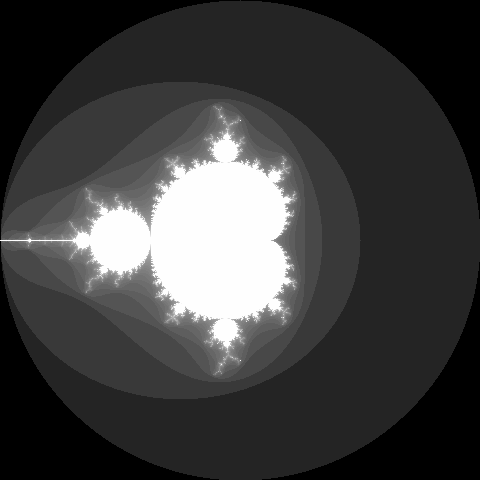

In [2]:
func c64Abs(c complex64) float32 {
	return math32.Hypot(real(c), imag(c))
}

func mandelbrot(cx, cy float32, maxIterations int) int {
	c := complex(cx, cy)
	z := complex(float32(0), float32(0))
	for n := 0; n < maxIterations; n++ {
		z = z*z + c
		if c64Abs(z) > 2 {
			return n
		}
	}
	return maxIterations
}

func mandelbrotGo(width, height, maxIterations int, xmin, ymin, xmax, ymax float32) *image.RGBA {
	img := image.NewRGBA(image.Rect(0, 0, width, height))
	logMaxIterations := math32.Log(float32(maxIterations + 1))
	rows := make(chan int, height)
	for y := range height {
		rows <- y
	}
	close(rows)

	// Set up worker pool of runtime.NumCPU() to process rows.
	// We assign a whole row as a task because pixel would be to fine-grained.
	var wg sync.WaitGroup
	for _ = range runtime.NumCPU() {
		wg.Add(1)
		go func() {
			for y := range rows {
				cy := ymin + (ymax-ymin)*float32(y)/float32(height)
				for x := 0; x < width; x++ {
					cx := xmin + (xmax-xmin)*float32(x)/float32(width)
					iter := mandelbrot(cx, cy, maxIterations)

					// Map iteration count to color
					colorVal := uint8(255 * math32.Log(float32(iter+1)) / logMaxIterations)
					img.Set(x, y, color.RGBA{colorVal, colorVal, colorVal, 255})
				}
			}
			wg.Done()
		}()
	}
	wg.Wait()
	return img
}

func mainPureGo() {
	fmt.Printf("Using %d workers.\n", runtime.NumCPU())
	start := time.Now()
	img := mandelbrotGo(480, 480, 128, -2, -2, 2, 2)
	fmt.Printf("\tElapsed: %s\n", time.Since(start))
	must.M(gonbui.DisplayImage(img))
}

//gonb:%exec mainPureGo

## XLA version

Same computation as above, but done in a vectorial fashion.

First we use the `go-xla` package from the local disk: only needed if the `go-xla` is cloned locally.

In [3]:
!*rm -f go.work && go work init && go work use . ${HOME}/Projects/go-xla
%goworkfix

	- Added replace rule for module "github.com/gomlx/go-xla" to local directory "/home/janpf/Projects/go-xla".


We create a container for the PJRT plugin and compiled code. The image size, number of iterations are fixed. But then we can execute it really fast for different areas (xmin, ymin, xmax and ymax).

Compiling XLA program:
	Elapsed: 1.50885913s
Generating image:
	Elapsed: 6.653156ms
Generating image (2nd time):
	Elapsed: 5.890319ms


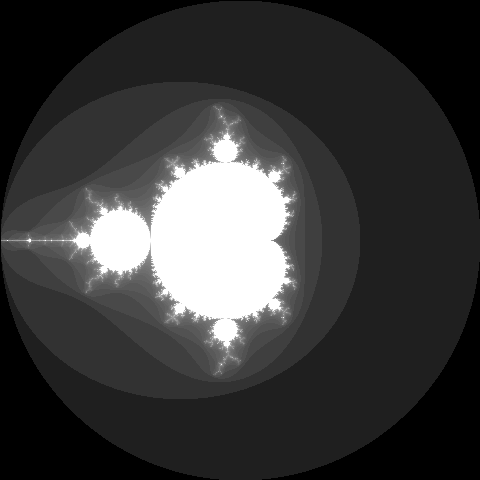

In [5]:
import (
    "github.com/gomlx/go-xla/pkg/stablehlo"
	"github.com/gomlx/go-xla/pkg/types"
	"github.com/gomlx/go-xla/pkg/types/shapes"
)

var flagPluginName = flag.String("plugin", "cpu", "PRJT plugin name or full path")

type MandelbrotGenerator struct {
	plugin                       *pjrt.Plugin
	client                       *pjrt.Client
	width, height, maxIterations int
    computation []byte      // Kept for debugging only
	exec                         *pjrt.LoadedExecutable
}

func NewMandelbrotGenerator(width, height, maxIterations int) *MandelbrotGenerator {
	m := &MandelbrotGenerator{
		plugin:        must.M1(pjrt.GetPlugin(*flagPluginName)),
		width:         width,
		height:        height,
		maxIterations: maxIterations,
	}
	pjrt.SuppressAbseilLoggingHack(func() {
		m.client = must.M1(m.plugin.NewClient(nil))
	})
	m.Build()
	return m
}

func (m *MandelbrotGenerator) Finalize() {
	if m.exec != nil {
		m.exec.Destroy()
		m.exec = nil
	}
	if m.client != nil {
		pjrt.SuppressAbseilLoggingHack(func() {
			m.client.Destroy()
		})
		m.client = nil
	}
	m.plugin = nil
}

// Build the StableHLO computation that generates the colors (number of iterations to diverge) of the
// Mandelbrot set.
func (m *MandelbrotGenerator) Build() {
	// Create XlaBuilder object and set the dtype and shapes we'll use.
	builder := stablehlo.New("mandelbrot")
    fn := builder.Main()  // The "main" function we are going to build.
	dtype := dtypes.F32
	scalarShape := shapes.Make(dtype)
	imageShape := shapes.Make(dtype, m.height, m.width)

	// The inputs for the computation are just the (minX, minY) - (maxX, maxY) area we are going to draw.
	// Notice the number of pixels in the image (the size of the matrix we are going to calculate) is
	// fixed -- if we change it we need to re-create the XLA computation.
	minX := must.M1(fn.NamedInput("minX", scalarShape))
	minY := must.M1(fn.NamedInput("minY", scalarShape))
	maxX := must.M1(fn.NamedInput("maxX", scalarShape))
	maxY := must.M1(fn.NamedInput("maxY", scalarShape))

	// Create the matrix (width, height) of complex numbers that are the input for each pixel.
	// The real (cx) part grows left to right (axis 1), and complex (cy) part grows bottom to top (axis 0).
	cx := must.M1(fn.Iota(imageShape, 1))
	normalizeX := must.M1(stablehlo.Divide(
		must.M1(stablehlo.Subtract(maxX, minX)),
		must.M1(fn.ConstantFromScalar(float32(m.width))),
    ))
    normalizeX = must.M1(stablehlo.BroadcastInDim(
        normalizeX, imageShape, nil))
	cx = must.M1(stablehlo.Multiply(cx, normalizeX))
    minXImage := must.M1(stablehlo.BroadcastInDim(
        minX, imageShape, nil))
	cx = must.M1(stablehlo.Add(cx, minXImage))
	cy := must.M1(fn.Iota(imageShape, 0))
	normalizeY := must.M1(stablehlo.Divide(
		must.M1(stablehlo.Subtract(maxY, minY)),
		must.M1(fn.ConstantFromScalar(float32(m.height))),
    ))
    normalizeY = must.M1(stablehlo.BroadcastInDim(
        normalizeY, imageShape, nil))
	cy = must.M1(stablehlo.Multiply(cy, normalizeY))
    minYImage := must.M1(stablehlo.BroadcastInDim(
        minY, imageShape, nil))
	cy = must.M1(stablehlo.Add(cy, minYImage))

	// c is the complex number that represents the position of the pixel and the value added to the recursive z function.
	c := must.M1(stablehlo.Complex(cx, cy))

	// z starts with complex64(0) for each pixel.
	zeroC64 := must.M1(fn.ConstantFromScalar(complex64(0)))
    imageC64Shape := shapes.Make(dtypes.Complex64, m.height, m.width)
	z := must.M1(stablehlo.BroadcastInDim(zeroC64, imageC64Shape, nil))

	// Some constants, and we initialize the currentIter.
	zero := must.M1(fn.ConstantFromScalar(float32(0)))
	one := must.M1(fn.ConstantFromScalar(float32(1)))
	maxIter := must.M1(fn.ConstantFromScalar(float32(m.maxIterations)))
	currentIter := zero

	// result start with the maxIter and at each iteration is updated if z reaches the divergence limit.
	// So result can only decrease in value -- at each iteration we take the minimun.
	result := must.M1(stablehlo.BroadcastInDim(maxIter, imageShape, nil))
	divergeLimit := must.M1(fn.ConstantFromScalar(float32(2)))
    divergeLimit = must.M1(stablehlo.BroadcastInDim(
        divergeLimit, imageShape, nil))

	// Looping over the iterations: notice that while we are looping in Go, the computation graph
	// doesn't have any loops (yet), it's simply generating a giant spaguetti like computation, "loop-unrolling"
	// the whole loop of iterations.
	for _ = range m.maxIterations {
		// Recursive z_{n+1}=z_{n}^2+c
		z = must.M1(stablehlo.Multiply(z, z))
		z = must.M1(stablehlo.Add(z, c))

		// Check pixels that diverged.
        absZ := must.M1(stablehlo.Abs(z))
		diverged := must.M1(stablehlo.Compare(absZ, divergeLimit, types.CompareGE, types.CompareFloat))

		// Update result only for those pixels that diverged.
        currentIterImage := must.M1(stablehlo.BroadcastInDim(
            currentIter, imageShape, nil))

		resultUpdate := must.M1(stablehlo.Minimum(result, currentIterImage))
		result = must.M1(stablehlo.Select(diverged, resultUpdate, result))

		// currentIter++
		currentIter = must.M1(stablehlo.Add(currentIter, one))
	}
    // What we want as output.
    must.M(fn.Return(result))

	// This finishes the building of the computation, which we then immediately compile and leave it ready to
	// be executed.
	m.computation = must.M1(builder.Build())
	m.exec = must.M1(m.client.Compile().WithStableHLO(m.computation).Done())
}

// Exec executes the compiled computation that generates the matrix of values for the Mandelbrot image.
func (m *MandelbrotGenerator) Exec(minX, minY, maxX, maxY float32) *image.RGBA {
	// Create the buffers that PJRT takes to feed the computation.
	inputs := make([]*pjrt.Buffer, 4)
	for ii, value := range []float32{minX, minY, maxX, maxY} {
		inputs[ii] = must.M1(pjrt.ScalarToBuffer(m.client, value))
	}

	// Execute the computation: it has only one output, the resulting the matrix, which we take.
	outputBuffer := must.M1(m.exec.Execute(inputs...).Done())[0]

	// The result is in accelerator memory, this transfers the buffer back to Go-land, in the form
	// of a flat slice, and the dimensions (width x height). Since we know the dimensions, we just
	// discard it here.
	flat, _ := must.M2(pjrt.BufferToArray[float32](outputBuffer))
	outputBuffer.Destroy()

	// Create the image from the returned matrix, with the number of iterations.
	// Notice we take the `log(#iterations + 1)` as the color to decrease the contrast.
	img := image.NewRGBA(image.Rect(0, 0, m.width, m.height))
	pos := 0
	logMaxIterations := math32.Log(float32(m.maxIterations + 1))
	for y := 0; y < m.height; y++ {
		for x := 0; x < m.width; x++ {
			// Map iteration count to color
			colorVal := uint8(255 * math32.Log(flat[pos]+1) / logMaxIterations)
			pos++
			img.Set(x, y, color.RGBA{colorVal, colorVal, colorVal, 255})
		}
	}
	return img
}

func mainXlaDemo() {
	fmt.Println("Compiling XLA program:")
	start := time.Now()
	m := NewMandelbrotGenerator(480, 480, 256)
	fmt.Printf("\tElapsed: %s\n", time.Since(start))

	fmt.Println("Generating image:")
	start = time.Now()
	img := m.Exec(-2, -2, 2, 2)
	fmt.Printf("\tElapsed: %s\n", time.Since(start))

    fmt.Println("Generating image (2nd time):")
	start = time.Now()
	img = m.Exec(-2, -2, 2, 2)
	fmt.Printf("\tElapsed: %s\n", time.Since(start))

	must.M(gonbui.DisplayImage(img))
	m.Finalize()
}

%exec mainXlaDemo

Compiling XLA program:
	Elapsed: 3.524286239s
Generating image:
	Elapsed: 115.48393ms
Generating image (2nd time):
	Elapsed: 4.587328ms


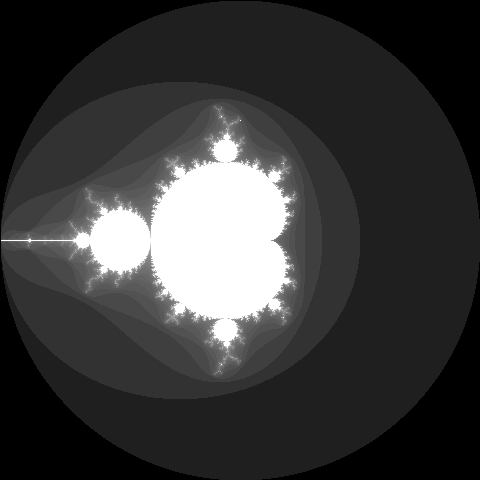

In [7]:
%% -plugin=cuda
mainXlaDemo()

## Example of [StableHLO](https://openxla.org/stablehlo/) code

This is what XLA's PJRT consumes, and what [github.com/gomlx/go-xla/pkg/stablehlo](https://github.com/gomlx/go-xla/pkg/stablehlo) outputs:

In [45]:
%%
m := NewMandelbrotGenerator(480, 480, 2)  // Only with 2 iterations, to limit the size
fmt.Printf("%s\n", m.computation)

func.func @main(%minX: tensor<f32>, %minY: tensor<f32>, %maxX: tensor<f32>, %maxY: tensor<f32>) -> tensor<480x480xf32> {
  %0 = "stablehlo.iota"() { iota_dimension = 1 : i64 } : () -> tensor<480x480xf32>
  %1 = "stablehlo.subtract"(%maxX, %minX) : (tensor<f32>, tensor<f32>) -> tensor<f32>
  %2 = "stablehlo.constant"() { value = dense<480.0> : tensor<f32> } : () -> tensor<f32>
  %3 = "stablehlo.divide"(%1, %2) : (tensor<f32>, tensor<f32>) -> tensor<f32>
  %4 = "stablehlo.broadcast_in_dim"(%3) { broadcast_dimensions = array<i64> } : (tensor<f32>) -> tensor<480x480xf32>
  %5 = "stablehlo.multiply"(%0, %4) : (tensor<480x480xf32>, tensor<480x480xf32>) -> tensor<480x480xf32>
  %6 = "stablehlo.broadcast_in_dim"(%minX) { broadcast_dimensions = array<i64> } : (tensor<f32>) -> tensor<480x480xf32>
  %7 = "stablehlo.add"(%5, %6) : (tensor<480x480xf32>, tensor<480x480xf32>) -> tensor<480x480xf32>
  %8 = "stablehlo.iota"() { iota_dimension = 0 : i64 } : () -> tensor<480x480xf32>
  %9 = "stablehlo.su

## Benchmark on large resolution image

We use a reference image of 10000x10000 pixels, with 256 iterations.

| **Configuration** | **Go CPU** | **PJRT CPU** | **PJRT GPU** |
|:---:|:---:|:---:|:---:|
| Intel i9-12900K+Nvidia2080Ti GPU | 0.5s | 1.9s | 1.7s |

Duh ... this is a horrible demo for speed gains :) since this algorithm doesn't benefit from vectorial processing: the vectorial version keeps calculating all maxIterations on the whole image, while the normal CPU version stops the processing as soon as things diverge. See next session to observe what happens if we limit the area of the plot to where we need all the itereaions (where most of the area is white).

In [8]:
%test -test.bench=. --plugin=cuda -test.v

const (
	benchmarkWidth      = 10000
	benchmarkHeight     = 10000
	benchmarkIterations = 128 // 256
)

func BenchmarkMandelbrotGo(b *testing.B) {
	for i := 0; i < b.N; i++ {
		_ = mandelbrotGo(benchmarkWidth, benchmarkHeight, benchmarkIterations, -2, -2, 2, 2)
	}
}

func BenchmarkMandelbrotPJRT(b *testing.B) {
	var m *MandelbrotGenerator
	b.Run("compile", func(b *testing.B) {
		for i := 0; i < b.N; i++ {
			if m != nil {
				m.Finalize()
			}
			m = NewMandelbrotGenerator(benchmarkWidth, benchmarkHeight, benchmarkIterations)
		}
	})
	b.Run("exec", func(b *testing.B) {
        // Warm up:
        for _ = range 3 {
            _ = m.Exec(-2, -2, 2, 2)
        }

        // Actually measuring.
        b.ResetTimer()
		for i := 0; i < b.N; i++ {
			_ = m.Exec(-2, -2, 2, 2)
		}
	})
	m.Finalize()
}

goos: linux
goarch: amd64
pkg: gonb_c64e0a9c
cpu: AMD Ryzen 9 9950X3D 16-Core Processor          
BenchmarkMandelbrotGo
BenchmarkMandelbrotGo-32      	       2	 507018204 ns/op
BenchmarkMandelbrotPJRT
BenchmarkMandelbrotPJRT/compile
BenchmarkMandelbrotPJRT/compile-32         	       1	3775227687 ns/op
BenchmarkMandelbrotPJRT/exec
BenchmarkMandelbrotPJRT/exec-32            	       1	1711963997 ns/op
PASS


### Benchmark On Non-Divergent Area

Just for the sake of demonstrating XLA speed gains (in the right scenarios), let's select an area of the fractal where most of the pixels will require MaxIterations
iterations to be calculated (where everything is white).

So, in the area $-0.5 <= x < 0.5$ and $-0.5 <= y < 0.5$ we get the following timings:

| **Configuration** | **Go CPU** | **PJRT CPU** | **PJRT GPU** |
|:---:|:---:|:---:|:---:|
| Intel i9-12900K+Nvidia2080Ti GPU | 5.4 | 2.2s | 1.8s |


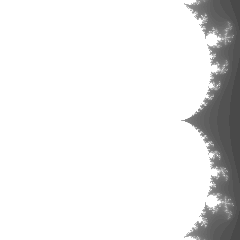

In [9]:
func mainZoomInDemo() {
	var minX, minY, maxX, maxY float32 = -0.5, -0.5, 0.5, 0.5
	
	must.M(gonbui.DisplayImage(
		mandelbrotGo(240, 240, 256, minX, minY, maxX, maxY)))
}
//gonb:%exec mainZoomInDemo

In [10]:
func mainZoomInBench() {
	const (
        minX, minY, maxX, maxY float32 = -0.5, -0.5, 0.5, 0.5
		benchmarkWidth      = 10000
		benchmarkHeight     = 10000
		benchmarkIterations = 256
	)

	iters := benchmarkIterations
	fmt.Println("Go implementation:")
	start := time.Now()
	_ = mandelbrotGo(benchmarkWidth, benchmarkHeight, iters, minX, minY, maxX, maxY)
	fmt.Printf("\tElapsed: %s\n", time.Since(start))

	fmt.Println("Compiling XLA program:")
	start = time.Now()
	m := NewMandelbrotGenerator(benchmarkWidth, benchmarkHeight, iters)
	fmt.Printf("\tElapsed: %s\n", time.Since(start))

	fmt.Println("PJRT Generating image:")
	_ = m.Exec(minX, minY, maxX, maxY)
	start = time.Now()
	_ = m.Exec(minX, minY, maxX, maxY)
	fmt.Printf("\tElapsed: %s\n", time.Since(start))
	m.Finalize()
}

%exec mainZoomInBench --plugin=cuda

Go implementation:
	Elapsed: 5.085736096s
Compiling XLA program:


I1212 07:47:30.004019   83519 subprocess_compilation.cc:347] ptxas warning : Registers are spilled to local memory in function 'loop_compare_select_fusion', 744 bytes spill stores, 744 bytes spill loads



	Elapsed: 8.613934409s
PJRT Generating image:
	Elapsed: 1.757862931s
